In [1]:
import torch
import cv2 as cv
import matplotlib.pyplot as plt
import sys

face_alignment_dir = r"C:\Users\KO SEONGHUN\Desktop\deepfake_curry\Code\face-alignment-master\face_alignment2"
sys.path.append(face_alignment_dir)

from face_alignment.detection.sfd import sfd_detector as sfd_detector0

c:\Users\KO SEONGHUN\miniconda3\envs\face-alignment\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# device = torch.device("cpu")
s3fd_model0=sfd_detector0.SFDDetector("cpu",filter_threshold=0.9)
#jpeg-3维,png-4维(+alpha)
img_path=r"two_face.jpeg"
#ground_truth
ground_truth_box=s3fd_model0.detect_from_image(img_path)
# print(ground_truth_box)
#输出结果
# [array([248.84192848,  97.09281158, 315.1940937 , 191.27245331,0.99997199]), 
# array([353.50476396,  42.75163412, 429.19740617, 146.62346792,0.99988282])]

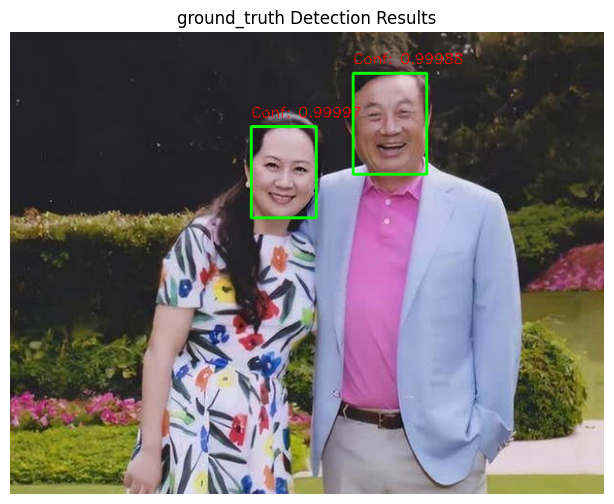

In [ ]:
# 读取图片
image = cv.imread(img_path)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)  # 转换为 RGB 格式

# 遍历检测框并绘制
for box in ground_truth_box:
    x1, y1, x2, y2, confidence = box  # 解包坐标和置信度
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)  # 转为整数像素
    cv.rectangle(image, (x1, y1), (x2, y2), color=(0,255, 0), thickness=2)  # 蓝色框
    text = f"Conf: {confidence:.5f}"
    cv.putText(image, text, (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# 显示结果
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")
plt.title("ground_truth Detection Results")
plt.show()

In [ ]:
def calculate_iou(box1, box2):
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    # 判断是否有重叠区域
    if x_right < x_left or y_bottom < y_top:
        return 0.0  # 没有交集

    # 交集面积
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    # 并集面积
    union_area = box1_area + box2_area - intersection_area
    iou = intersection_area / union_area
    return iou

#IOU 阈值
def classify_index_by_iou(pred_box,ground_truth_box,thresh_IOU = 0.3):
    potential_true_index = []
    potential_false_index = []

    for i,pred in enumerate(pred_box):    
        match_found=False
        for truth in ground_truth_box:
            if calculate_iou(pred,truth)>thresh_IOU:
                potential_true_index.append(i)
                match_found=True
                break
        if not match_found:
            potential_false_index.append(i)
    return potential_true_index,potential_false_index

In [ ]:
def loss_function(pred_conf, potential_true_index, potential_false_index): #, threshold_false_box=200
    true_detection_loss = torch.tensor(0.0, dtype=torch.float32, device='cpu')
    false_detection_loss = torch.tensor(0.0, dtype=torch.float32, device='cpu')
    # true_detection_loss=torch.log(1-pred_conf[potential_true_index]).sum()
    # false_detection_loss=torch.log(pred_conf[potential_false_index[:threshold_false_box]]).sum()
    for i in potential_true_index:
        true_detection_loss += torch.log(1 - pred_conf[i])
    for j in potential_false_index: #[:threshold_false_box]
        false_detection_loss += torch.log(pred_conf[j])
    loss = torch.add(true_detection_loss,false_detection_loss)
    print(loss)
    return loss

In [ ]:
from detection.sfd import sfd_detector
import time
# eps alpha steps
# 0.5 0.5~3 15 good
EPS=0.7
ALPHA=3
ATTACK_STEPS=15
def pgd_attack(model, image_orig, eps=EPS, alpha=ALPHA, attack_steps=ATTACK_STEPS, device='cpu'):
    image_orig = image_orig.to(device)
    perturbation = torch.zeros_like(image_orig,dtype=torch.float32,requires_grad=True).to(device)

    input_data=torch.add(image_orig,perturbation)
    for step in range(attack_steps):
        t0=time.time()
        pred_result = model.detect_from_image((input_data).clamp(0, 255))
        pred_box, pred_conf = [], []
        print(len(pred_result))
        #threshold count
        for result in pred_result[:300]:
            pred_box.append(result[:4])
            pred_conf.append(result[4])
        # print(pred_box)
        # print(pred_conf)
        
        potential_true_index,potential_false_index=classify_index_by_iou(pred_box,ground_truth_box,thresh_IOU=0.3)
        print(potential_true_index)
        #TODO:没有potential_ture_index，停止循环
        if not potential_true_index:
            print("no potential_true_index anymore")
            t1=time.time()
            print(f"step: {step}, spent time:{t1-t0}")
            break
        # 计算损失
        loss = loss_function(pred_conf,potential_true_index,potential_false_index)
        #清除模型参数的梯度
        model.face_detector.zero_grad()
        loss.backward(retain_graph=True)
        # 梯度更新
        grad=perturbation.grad.sign()

        perturbation = torch.clamp(perturbation + alpha * grad,min=-eps,max=eps).detach()
        perturbation.requires_grad_()
        # print(perturbation.grad)   #None,因此不用puerturbation.grad.zero_()
        input_data = torch.clamp(torch.add(input_data,perturbation),min=0,max=255)
        t1=time.time()
        print(f"step: {step}, spent time:{t1-t0}")

    return input_data.detach()

def load_image(img_path):
    # 加载图像并转为张量
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float()
    return img

# pgd攻击代码
img_path = "two_face.jpeg"
s3fd_model = sfd_detector.SFDDetector("cpu", filter_threshold=0.01)
image_orig = load_image(img_path)
adv_image = pgd_attack(s3fd_model, image_orig, device="cpu")

27
[0, 1]
tensor(-87.3452, grad_fn=<AddBackward0>)
step: 0, spent time:10.717501640319824
39
[0, 1]
tensor(-98.6956, grad_fn=<AddBackward0>)
step: 1, spent time:10.478015184402466
53
[0, 1]
tensor(-120.7914, grad_fn=<AddBackward0>)
step: 2, spent time:10.346004962921143
73
[0, 2]
tensor(-151.8392, grad_fn=<AddBackward0>)
step: 3, spent time:12.007952213287354
112
[1, 3]
tensor(-224.4267, grad_fn=<AddBackward0>)
step: 4, spent time:12.850639581680298
141
[1, 9]
tensor(-248.9408, grad_fn=<AddBackward0>)
step: 5, spent time:11.890184879302979
181
[0, 55]
tensor(-309.2727, grad_fn=<AddBackward0>)
step: 6, spent time:12.412485599517822
245
[19, 201]
tensor(-400.1110, grad_fn=<AddBackward0>)
step: 7, spent time:13.127597093582153
305
[60]
tensor(-464.1950, grad_fn=<AddBackward0>)
step: 8, spent time:12.70628833770752
370
[276]
tensor(-317.7450, grad_fn=<AddBackward0>)
step: 9, spent time:13.897067785263062
410
[]
no potential_true_index anymore
step: 10, spent time:3.4503939151763916


'\n20s\n\n'

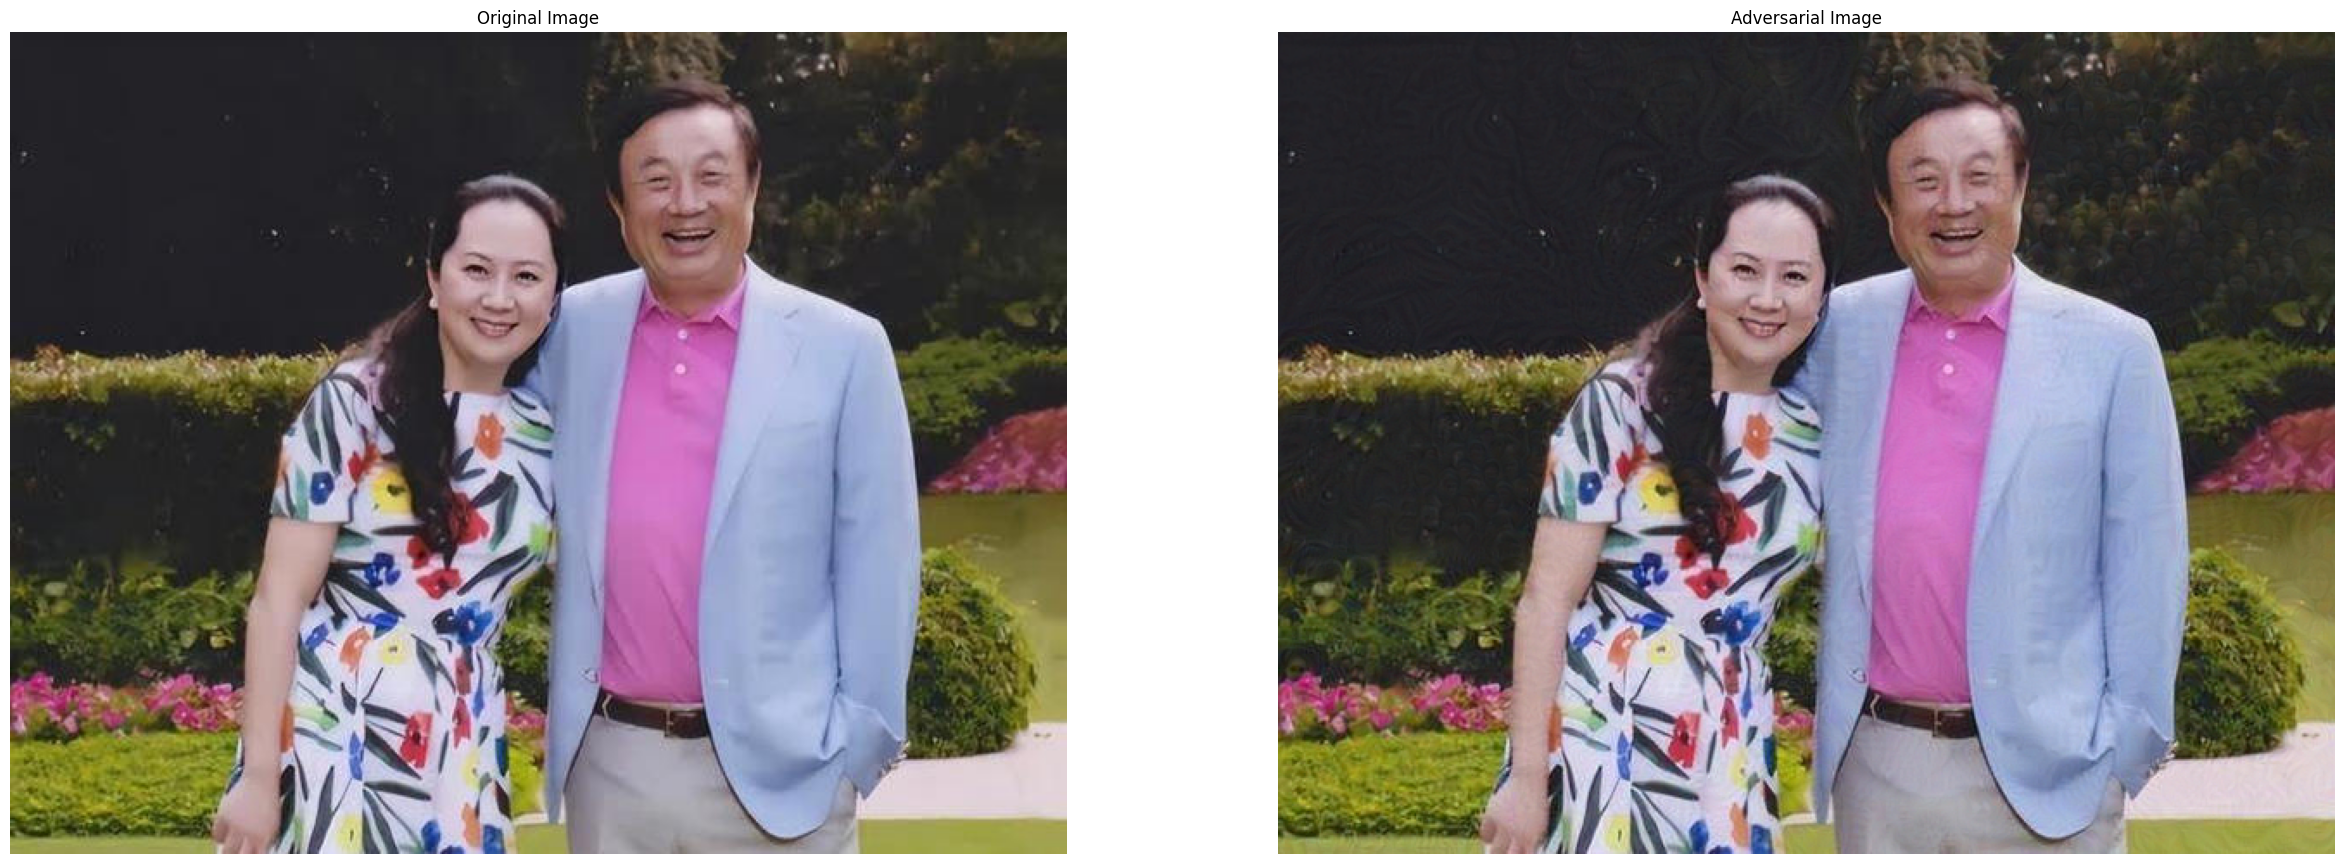

In [88]:
image_orig2 = image_orig.squeeze().permute(1, 2, 0).cpu().numpy().astype('uint8') # 将 img 从 (C, H, W) 转换为 (H, W, C)
adv_image2 = adv_image.squeeze().permute(1, 2, 0).cpu().numpy().astype('uint8')  # 同样转换 input_data

fig, axes = plt.subplots(1, 2, figsize=(30, 15))

# 显示原图 img
axes[0].imshow(image_orig2)  # 转换为整数类型以确保正确显示图像
axes[0].set_title("Original Image")
axes[0].axis("off")  # 关闭坐标轴

# 显示对抗样本 input_data
axes[1].imshow(adv_image2)  # 同样转换为整数类型
axes[1].set_title("Adversarial Image")
axes[1].axis("off")  # 关闭坐标轴

# 显示图像
plt.show()

In [89]:
save_path = f"result_img/adv_image_saved_{EPS}_{ALPHA}_{ATTACK_STEPS}.png"

cv.imwrite(save_path, cv.cvtColor(adv_image2, cv.COLOR_RGB2BGR))
print(f"图片已保存到: {save_path}")

图片已保存到: result_img/adv_image_saved_0.7_3_15.png


In [ ]:
s3fd_model2 = sfd_detector.SFDDetector("cpu", filter_threshold=0.6)
result=s3fd_model2.detect_from_image(adv_image)

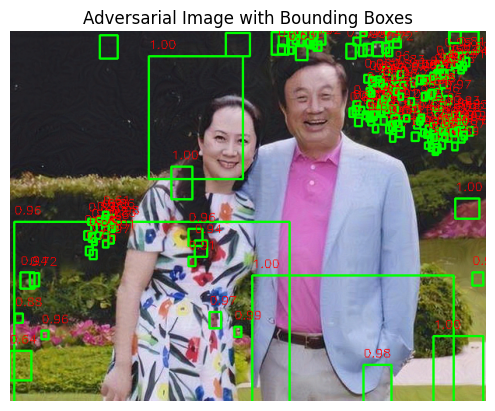

In [91]:
for detection in result:
    x1, y1, x2, y2, confidence = detection.detach().cpu().numpy()
    # 绘制矩形框
    adv_image_np = cv.rectangle(
        adv_image2,
        (int(x1), int(y1)),  # 左上角
        (int(x2), int(y2)),  # 右下角
        (0,255, 0),         # 蓝色框
        2                    # 框线厚度
    )
    # 绘制置信度
    adv_image_np = cv.putText(
        adv_image2,
        f"{confidence:.2f}",
        (int(x1), int(y1) - 10),  # 文字位置
        cv.FONT_HERSHEY_SIMPLEX,
        0.5,                      # 字体大小
        (255, 0, 0),              # 蓝色文字
        1                         # 文字厚度
    )

# 使用 matplotlib 显示图像
plt.imshow(adv_image_np)
plt.axis("off")
plt.title("Adversarial Image with Bounding Boxes")
plt.show()